In [5]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import os
import datetime

# Set Parameters
image_size = (96, 96)
batch_size = 16
num_classes = 5
epochs = 50

train_dir = 'data/train'
test_dir = 'data/test'

Loading and Preprocessing Data

In [6]:
# Load Data
def load_data(train_dir, test_dir, image_size, batch_size):
    train_dataset = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=image_size,
        batch_size=batch_size
    )
    test_dataset = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=image_size,
        batch_size=batch_size
    )
    return train_dataset.map(normalize), test_dataset.map(normalize)

# Normalize Data
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset, test_dataset = load_data(train_dir, test_dir, image_size, batch_size)

Found 6369 files belonging to 5 classes.
Found 2749 files belonging to 5 classes.


Defining two distinct CNN models

In [7]:
def create_cnn_model_1(input_shape, num_classes):
    """
    Simpler CNN model:
      - Only 2 convolutional layers (16 and 32 filters)
      - Smaller Dense layer (64 units)
      - Moderate dropout (0.3)
    """
    model = models.Sequential()
    
    # First Conv + Pool block
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second Conv + Pool block
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))  # 30% dropout to reduce overfitting
    model.add(layers.Dense(num_classes, activation='softmax'))  # Final output layer

    return model

def create_cnn_model_2(input_shape, num_classes):
    """
    More complex CNN model:
      - Additional convolution layers
      - Larger number of filters (32, 64, 128)
      - L2 regularization (weight decay) in several layers
      - Larger Dense layer (256 units)
      - Heavier dropout (0.5)
    """
    model = models.Sequential()
    
    # First Conv block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Conv block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Conv block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))  # 50% dropout
    model.add(layers.Dense(num_classes, activation='softmax'))  # Final output layer

    return model

Training Function

In [8]:
def train_model(model, train_dataset, test_dataset, epochs, model_name):
    """
    Compiles and trains the given model on the specified training dataset.
    Validation metrics are computed on the test dataset.
    Includes:
      - TensorBoard callback for logging
      - EarlyStopping callback to prevent overfitting
      - ReduceLROnPlateau for dynamic learning rate adjustment
    """
    # Compile the model with an Adam optimizer and sparse crossentropy
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create a log directory for TensorBoard logging
    log_dir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Early stopping if no improvement in validation loss over 5 epochs
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr]
    )
    return history

Build and Train both Models

In [9]:
# Define the input shape (Height, Width, Channels)
input_shape = (*image_size, 3)

# Create and train the first simpler model
cnn_model_1 = create_cnn_model_1(input_shape, num_classes)
history_1 = train_model(cnn_model_1, train_dataset, test_dataset, epochs, "Model_1")

# Create and train the second more complex model
cnn_model_2 = create_cnn_model_2(input_shape, num_classes)
history_2 = train_model(cnn_model_2, train_dataset, test_dataset, epochs, "Model_2")

# Print summaries to see the difference in architecture
cnn_model_1.summary()
cnn_model_2.summary()

/home/fasc/MLHW2_car_racing/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1736114547.855552    5627 service.cc:148] XLA service 0x7fdec800c040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736114547.855807    5627 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-01-05 23:02:27.890316: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736114547.997773    5627 cuda_dnn.cc:529] Loaded cuDNN version 90300


 59/399 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2868 - loss: 1.5541

I0000 00:00:1736114549.257112    5627 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4124 - loss: 1.4233 - val_accuracy: 0.6213 - val_loss: 1.0907 - learning_rate: 1.0000e-04
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5405 - loss: 1.2252 - val_accuracy: 0.6373 - val_loss: 1.0528 - learning_rate: 1.0000e-04
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5707 - loss: 1.1750 - val_accuracy: 0.6475 - val_loss: 1.0293 - learning_rate: 1.0000e-04
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5853 - loss: 1.1458 - val_accuracy: 0.6548 - val_loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5970 - loss: 1.1078 - val_accuracy: 0.6304 - val_loss: 1.0626 - learning_rate: 1.0000e-04
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6057 - loss: 1.0889 - val_accuracy: 0.6421 - val_loss: 1.0102 - learning_rate: 1.0000e-04
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6109 - lo

2025-01-05 23:02:57.048547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_162', 4 bytes spill stores, 4 bytes spill loads



399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4379 - loss: 5.5549 - val_accuracy: 0.6206 - val_loss: 2.1465 - learning_rate: 1.0000e-04
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5554 - loss: 2.0628 - val_accuracy: 0.6151 - val_loss: 1.5641 - learning_rate: 1.0000e-04
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5617 - loss: 1.5908 - val_accuracy: 0.5897 - val_loss: 1.4035 - learning_rate: 1.0000e-04
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5638 - loss: 1.4382 - val_accuracy: 0.6231 - val_loss: 1.3011 - learning_rate: 1.0000e-04
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5699 - loss: 1.3667 - val_accuracy: 0.6370 - val_loss: 1.2026 - learning_rate: 1.0000e-04
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5751 - loss: 1.3138 - val_accuracy: 0.6413 - val_loss: 1.2051 - learning_rate: 1.0000e-04
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5796 - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       991,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,990,129 (11.41 MB)

 Trainable params: 996,709 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,993,420 (7.60 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,385,521 (31.99 MB)

 Trainable params: 2,795,173 (10.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,590,348 (21.33 MB)

Plotting and Comparing results

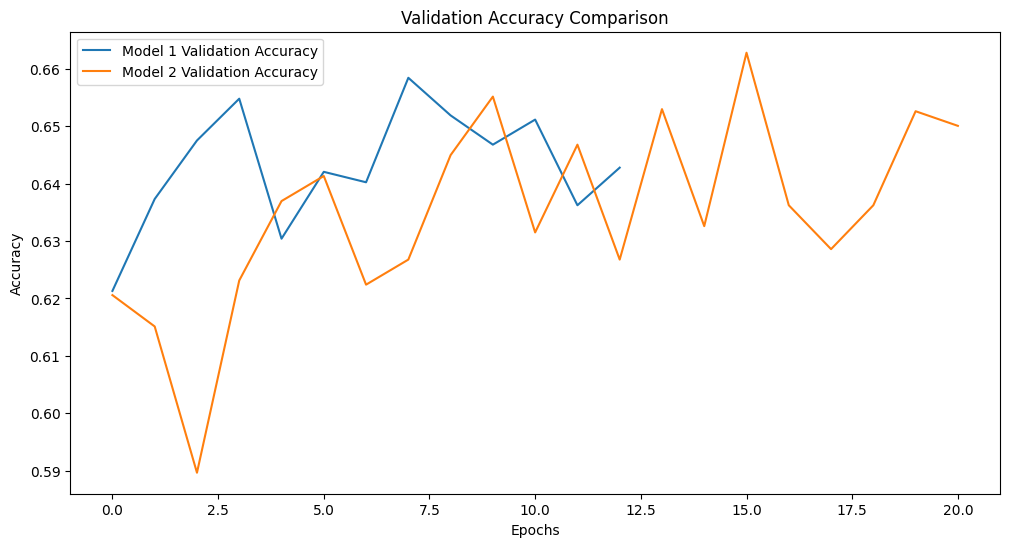

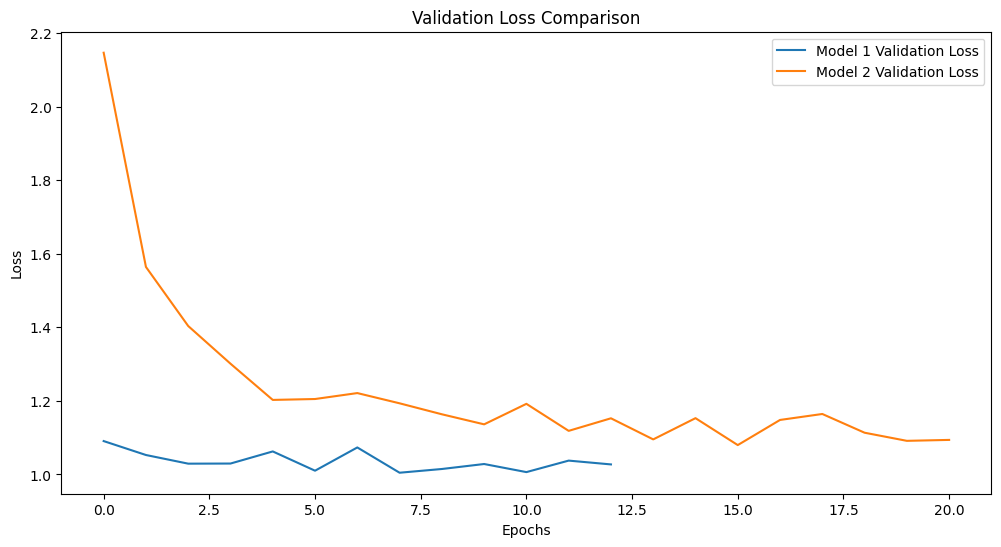

In [10]:
def plot_comparison(histories, labels):
    """
    Plots and compares validation accuracy and validation loss over epochs
    for multiple training histories.
    """
    plt.figure(figsize=(12, 6))
    # Accuracy Comparison
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'{labels[i]} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss Comparison
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=f'{labels[i]} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Compare Model 1 vs Model 2 performance
plot_comparison([history_1, history_2], ['Model 1', 'Model 2'])

Evaluating the models on the test data

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6604 - loss: 1.0102
Model 1 Test Accuracy: 0.66
Model 1 Test Loss: 1.00
  1/172 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step

2025-01-05 23:04:14.229626: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


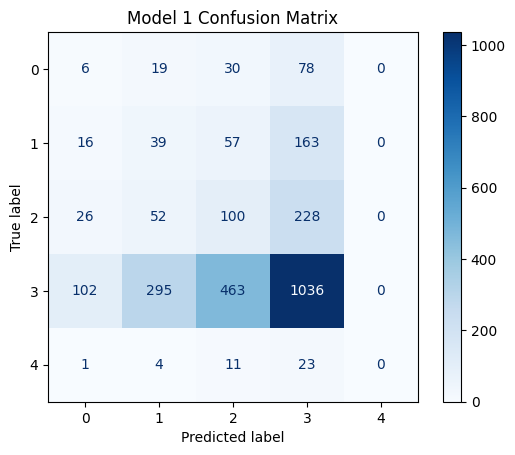

Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.05      0.04       133
           1       0.10      0.14      0.11       275
           2       0.15      0.25      0.19       406
           3       0.68      0.55      0.61      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.43      2749
   macro avg       0.19      0.20      0.19      2749
weighted avg       0.50      0.43      0.46      2749

 39/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6891 - loss: 1.0632

/home/fasc/MLHW2_car_racing/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fasc/MLHW2_car_racing/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fasc/MLHW2_car_racing/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6689 - loss: 1.0787
Model 2 Test Accuracy: 0.66
Model 2 Test Loss: 1.08


2025-01-05 23:04:15.821090: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


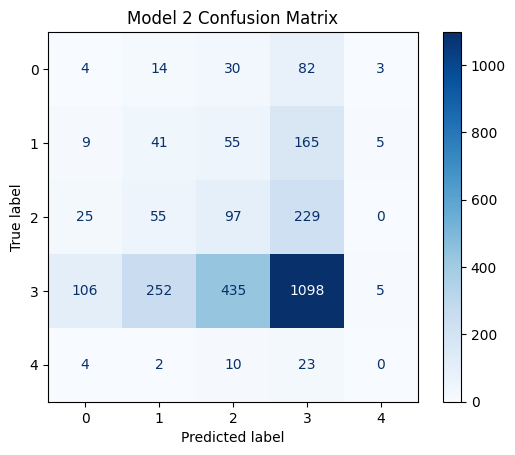

Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       133
           1       0.11      0.15      0.13       275
           2       0.15      0.24      0.19       406
           3       0.69      0.58      0.63      1896
           4       0.00      0.00      0.00        39

    accuracy                           0.45      2749
   macro avg       0.20      0.20      0.19      2749
weighted avg       0.51      0.45      0.48      2749



In [11]:

def evaluate_model(model, dataset, model_name):
    """
    Evaluates the model on the provided dataset and prints out:
      - Test Accuracy and Loss
      - Confusion Matrix
      - Classification Report
    """
    # Compute test loss and accuracy
    test_loss, test_accuracy = model.evaluate(dataset)
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}")
    print(f"{model_name} Test Loss: {test_loss:.2f}")

    # Extract the ground-truth labels
    y_true = np.concatenate([y.numpy() for x, y in dataset], axis=0)
    # Predict class probabilities for the dataset, then take argmax for class label
    y_pred = np.argmax(model.predict(dataset), axis=-1)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Print classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate both models
evaluate_model(cnn_model_1, test_dataset, "Model 1")
evaluate_model(cnn_model_2, test_dataset, "Model 2")